# KNN 

Dataset：Adult income dataset

URL：http://www.cs.toronto.edu/~delve/data/adult/desc.html

result：
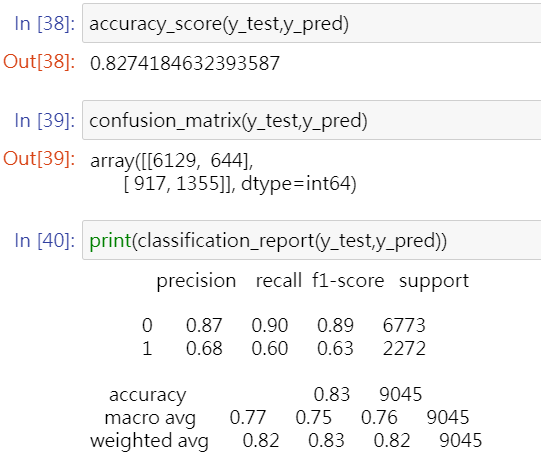

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import time

C:\anaconda3\envs\tf37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\anaconda3\envs\tf37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\anaconda3\envs\tf37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# 匯入資料 執行資料預處理

In [2]:
df=pd.read_csv("../2022-12-06knn/adult.csv",header=0)


In [3]:
df.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [6]:
#fnlwgt 在分析中不具意義
df=df.drop('fnlwgt',axis=1)

In [7]:
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [8]:
df.isin(['?']).sum() #都屬於類別型資料

age                   0
workclass          2799
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [9]:
df.drop(df.index[df['workclass'] == '?'],inplace=True)
df.drop(df.index[df['occupation'] == '?'],inplace=True)
df.drop(df.index[df['native-country'] == '?'],inplace=True)
#去除有空值的資料

In [10]:
df.shape

(45222, 14)

# 擷取類別型資料

In [11]:
df_category=df.select_dtypes(include='object')
df_numerical=df.select_dtypes(exclude='object')

In [12]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   age              45222 non-null  int64
 1   educational-num  45222 non-null  int64
 2   capital-gain     45222 non-null  int64
 3   capital-loss     45222 non-null  int64
 4   hours-per-week   45222 non-null  int64
dtypes: int64(5)
memory usage: 2.1 MB


In [13]:
df_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   workclass       45222 non-null  object
 1   education       45222 non-null  object
 2   marital-status  45222 non-null  object
 3   occupation      45222 non-null  object
 4   relationship    45222 non-null  object
 5   race            45222 non-null  object
 6   gender          45222 non-null  object
 7   native-country  45222 non-null  object
 8   income          45222 non-null  object
dtypes: object(9)
memory usage: 3.5+ MB


In [14]:
df_category.head()

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,United-States,<=50K
1,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,<=50K
2,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,>50K
3,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,>50K
5,Private,10th,Never-married,Other-service,Not-in-family,White,Male,United-States,<=50K


In [15]:
pd_category_dum=pd.get_dummies(df_category,drop_first=True)

In [16]:
pd_category_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 91 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   workclass_Local-gov                        45222 non-null  uint8
 1   workclass_Private                          45222 non-null  uint8
 2   workclass_Self-emp-inc                     45222 non-null  uint8
 3   workclass_Self-emp-not-inc                 45222 non-null  uint8
 4   workclass_State-gov                        45222 non-null  uint8
 5   workclass_Without-pay                      45222 non-null  uint8
 6   education_11th                             45222 non-null  uint8
 7   education_12th                             45222 non-null  uint8
 8   education_1st-4th                          45222 non-null  uint8
 9   education_5th-6th                          45222 non-null  uint8
 10  education_7th-8th                          452

In [17]:
df_final=pd.concat([df_numerical,pd_category_dum],axis=1)

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 96 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        45222 non-null  int64
 1   educational-num                            45222 non-null  int64
 2   capital-gain                               45222 non-null  int64
 3   capital-loss                               45222 non-null  int64
 4   hours-per-week                             45222 non-null  int64
 5   workclass_Local-gov                        45222 non-null  uint8
 6   workclass_Private                          45222 non-null  uint8
 7   workclass_Self-emp-inc                     45222 non-null  uint8
 8   workclass_Self-emp-not-inc                 45222 non-null  uint8
 9   workclass_State-gov                        45222 non-null  uint8
 10  workclass_Without-pay                      452

In [19]:
df_final.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,income_>50K
0,25,7,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,9,0,0,50,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,28,12,0,0,40,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,44,10,7688,0,40,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,34,6,0,0,30,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


# KNN

In [20]:
y=df_final['income_>50K']
X=df_final.drop('income_>50K',axis=1)


In [21]:
X

,age,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,50,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,40,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,10,7688,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,34,6,0,0,30,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,12,0,0,38,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48838,40,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,58,9,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,22,9,0,0,20,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train, X_test, y_train, y_test)

       age  educational-num  capital-gain  capital-loss  hours-per-week  \
14240   26               10             0             0              50   
11176   58                4             0             0              40   
22609   20               10             0             0              40   
27006   48               14             0             0              55   
47367   53                9             0             0              45   
...    ...              ...           ...           ...             ...   
32850   64                9             0             0              35   
22994   48               13             0             0              40   
46012   21               10             0          1721              35   
47046   38               10             0             0              25   
2957    19                9             0             0              10   

       workclass_Local-gov  workclass_Private  workclass_Self-emp-inc  \
14240                    0

In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [26]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [27]:
from sklearn.neighbors import KNeighborsClassifier


In [28]:
knn=KNeighborsClassifier()
params = {
        'n_neighbors':list(range(1,10)),
        'weights':['uniform','distance'],
        'metric':['minkoski','euclidean','manhattan']
    
        }
newknn=RandomizedSearchCV(estimator = knn, 
                                   param_distributions=params, 
                                   scoring='accuracy',cv = 5,
                                   n_jobs = -1,
                                   verbose = 1)

In [29]:

start = time.time()

newknn.fit(X_train, y_train)

end = time.time()

# 輸出結果

print("執行時間：%f 秒" % (end - start))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
執行時間：110.790879 秒


In [30]:
newknn.best_estimator_.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 9,
 'p': 2,
 'weights': 'uniform'}

In [31]:
newknn.best_score_

0.8271830970311613

# 最佳設置KNN

In [32]:
bestknn=KNeighborsClassifier(n_neighbors=9, leaf_size=30,metric='euclidean',weights= 'uniform')
bestknn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=9)

In [34]:
print('訓練集：',bestknn.score(X_train,y_train))
print('測試集：',bestknn.score(X_test,y_test))

訓練集： 0.858998811399508
測試集： 0.8274184632393587


In [36]:
y_pred=bestknn.predict(X_test)

In [37]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [38]:
accuracy_score(y_test,y_pred)

0.8274184632393587

In [39]:
confusion_matrix(y_test,y_pred)

array([[6129,  644],
       [ 917, 1355]], dtype=int64)

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      6773
           1       0.68      0.60      0.63      2272

    accuracy                           0.83      9045
   macro avg       0.77      0.75      0.76      9045
weighted avg       0.82      0.83      0.82      9045



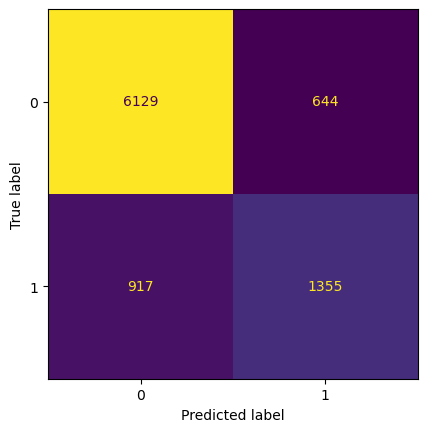

In [41]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(bestknn, X_test, y_test, colorbar=False)